Packages

keras

In [1]:
#tensorflow: use some TF tools
import tensorflow as tf
#Keras: Deep learning API. In TF 2.x, it is included in TF
from tensorflow import keras
from tensorflow.keras.models import Sequential


#Import Dense layer
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC

# import CNN Conv1D
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D
from tensorflow.keras.layers import SpatialDropout1D


import os

# ROC from skilearn
from sklearn.metrics import roc_auc_score

import pandas as pd

import matplotlib.pyplot as pyplot
%matplotlib inline


Hyper parameters

In [2]:
output_dir = "model_output/cnn"

# Training
epochs = 4
batch_size = 128

# vector space embed
n_dim = 64 #vector dimensions
n_unique_words = 5000
n_words_to_skip = 50
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2 # drop out for embedding layer

# CNN
n_conv = 256 # filters 
k_conv = 3 # kernel length

# Dense layer
n_dense = 256
dropout = 0.2

IMDb

In [3]:
from tensorflow.keras.datasets import imdb

In [4]:
#imdb.get_word_index()

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

Load IMDb

In [6]:
(x_train, y_train), (x_valid, y_valid) = \
    imdb.load_data(num_words=n_unique_words, skip_top=n_words_to_skip)

In [7]:
print(len(x_train))
print(len(x_valid))

25000
25000


In [8]:
len(x_train[0])

218

In [9]:
y_train[0:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

In [10]:
x_train[0]

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [11]:
word_indexes = imdb.get_word_index()
len(word_indexes)
#print(word_indexes)

88584

In [12]:
# Reserve 3 values (0, 1, 2) for special words
word_indexes = {k:(v+3) for k, v in word_indexes.items()}

In [13]:
# Add 3 special words
word_indexes["pad"] = 0
word_indexes["start"] = 1
word_indexes["unk"] = 2

In [14]:
word_indexes["unk"]

2

In [15]:
# Inverse key and values
index_word = {v:k for k, v in word_indexes.items()}

In [16]:
index_word[2]

'unk'

In [17]:
# print a sentence 
' '.join([index_word[id] for id in x_train[0]])

"unk unk unk unk unk brilliant casting location scenery story direction everyone's really suited unk part unk played unk unk could unk imagine being there robert unk unk unk amazing actor unk now unk same being director unk father came unk unk same scottish island unk myself unk unk loved unk fact there unk unk real connection unk unk unk unk witty remarks throughout unk unk were great unk unk unk brilliant unk much unk unk bought unk unk unk soon unk unk unk released unk unk unk would recommend unk unk everyone unk watch unk unk fly unk unk amazing really cried unk unk end unk unk unk sad unk unk know what unk say unk unk cry unk unk unk unk must unk been good unk unk definitely unk also unk unk unk two little unk unk played unk unk unk norman unk paul unk were unk brilliant children unk often left unk unk unk unk list unk think because unk stars unk play them unk grown up unk such unk big unk unk unk whole unk unk these children unk amazing unk should unk unk unk what unk unk done do

In [18]:
# Pad to get same length
max_review_length
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
len(x_train[0])

400

Dense Network with Embedding

In [19]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) # Input: vector of 100 words
# Output: word vector with n_dim(64) dimensions
# unique words = 5000
# Output: 5000 * 64 = 320 000 parameters

In [20]:
# Embedding dropout
model.add(SpatialDropout1D(drop_embed))

In [196]:
model.add(Flatten())
# Output: one dimensional vector for Dense Layer
# vector: 100 * 64 

In [21]:
# Convltional layer
model.add(Conv1D(n_conv, k_conv, activation='relu'))

# Dropout
model.add(GlobalMaxPool1D())


In [22]:
# Dense: 6400 * 64 = 409 000 parameters + 64 biases 
model.add(Dense(n_dense, activation="relu"))


In [23]:
model.add(Dropout(dropout))

In [24]:
# Output layer: sigmoid, 2 classes: 0 and 1
model.add(Dense(1, "sigmoid"))
# 64 parameters (one for each preceding layer neurons) + 1 bias = 65 params

In [25]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [28]:
# Model Checkpoint: to save model parameters after each epoch
modelcheckpoint = ModelCheckpoint(filepath= output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [29]:
# Train
model.fit(x_train, y_train,
    batch_size=batch_size, 
    epochs=epochs,
    verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 55s 2ms/sample - loss: 0.4917 - accuracy: 0.7340 - val_loss: 0.3205 - val_accuracy: 0.8602
Epoch 2/4
25000/25000 [==============================] - 55s 2ms/sample - loss: 0.2665 - accuracy: 0.8906 - val_loss: 0.2903 - val_accuracy: 0.8744
Epoch 3/4
25000/25000 [==============================] - 56s 2ms/sample - loss: 0.1897 - accuracy: 0.9285 - val_loss: 0.3101 - val_accuracy: 0.8733
Epoch 4/4
25000/25000 [==============================] - 56s 2ms/sample - loss: 0.1268 - accuracy: 0.9561 - val_loss: 0.3472 - val_accuracy: 0.8722


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 400, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [30]:
model.load_weights(output_dir + "/weights.02.hdf5") # Best val_loss: 0.3532

In [31]:
y_hat = model.predict(x_valid)

In [32]:
print(y_hat[1])
print(y_valid[1])
' '.join([index_word[id] for id in x_valid[1]])

[0.9968866]
1


'pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad unk unk unk requires unk lot unk unk because unk focuses unk mood unk character development unk plot unk very simple unk many unk unk scenes take place unk unk same set unk unk unk unk unk dennis character apartment unk unk unk builds unk unk disturbing climax unk unk unk characters create unk atmosphere unk unk sexual tension unk psychological unk unk very interesting unk robert unk directed unk considering unk style unk structure unk

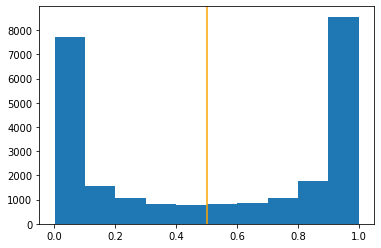

In [33]:
pyplot.hist(y_hat)
_ = pyplot.axvline(x=0.5, color="orange")

Use ROC instead of simple accuracy 

In [34]:
# from sickit-learn
pct_auc = roc_auc_score(y_valid, y_hat) * 100.0
'{:0.2f}'.format(pct_auc)

'94.97'

In [35]:
from sklearn.metrics import roc_curve 
fpr , tpr , thresholds = roc_curve ( y_valid , y_hat)

In [36]:
# false positive rate
fpr

array([0.     , 0.     , 0.     , ..., 0.99864, 0.9988 , 1.     ])

In [37]:
# True positive rate
tpr

array([0.0e+00, 8.0e-05, 5.6e-04, ..., 1.0e+00, 1.0e+00, 1.0e+00])

In [38]:
thresholds

array([1.9997475e+00, 9.9974746e-01, 9.9956930e-01, ..., 7.5927377e-04,
       7.5659156e-04, 3.2004714e-04], dtype=float32)

data frame

In [39]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)),
    columns=['y_hat', 'y'])

In [40]:
len(ydf)

25000

In [41]:
ydf.head(10)

,y_hat,y
0,0.056158,0
1,0.996887,1
2,0.873207,1
3,0.842341,0
4,0.976890,1
5,0.780034,1
6,0.968682,1
7,0.008423,0
8,0.966701,0
9,0.971602,1


In [42]:
# false positives
ydf[(ydf.y == 0) & (ydf.y_hat > 0.9)].head(1)

,y_hat,y
8,0.966701,0


In [43]:

' '.join([index_word[id] for id in x_valid[75]])

"pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad unk unk adventures unk unk unk unk unk unk unk unk unk unk unk unk unk i've yet run across unk would unk unk look far unk wide unk find anything unk unk unk level unk unk unk display unk unk unk acting \x96 bad editing \x96 bad direction \x96 bad special effects \x96 bad unk laughable plot \x96 bad lighting \x96 bad cinematography \x96 bad costume design \x96 bad unk silly everything else \x96 bad watching unk adventures unk unk unk unk unk enjoyable unk unk root unk even unk unk fan unk bad movies unk unk real unk test unk unk unk unk either unk unk lou unk unk unk any exist unk unk eight things unk learned unk watching unk adventures unk unk unk unk 1 unk unk don't unk unk budget unk 

In [44]:
# false negatives
ydf[(ydf.y == 1) & (ydf.y_hat < 0.1)].head(10)

,y_hat,y
100,0.021059,1
325,0.064545,1
333,0.097782,1
511,0.098036,1
581,0.040569,1
670,0.096844,1
1337,0.081778,1
1629,0.074367,1
1710,0.036154,1
1959,0.055348,1


In [45]:
' '.join([index_word[id] for id in x_valid[973]])

"pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad

Conclusion: 

ROC is '94.97'

Compared with Dense network ROC of '92.61'
 

Need of Recurrent Neural networks, which take into account the sequence of words.

Next module: Try RNN